**Note: be sure to add the folder DS-Private-Challenge-2020 to your drive (you can do this using the dropdown arrow next to the folder name in the path header in Drive) before running this notebook **

Load packages

In [0]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib
import pickle 
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import r2_score
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
import xgboost


1.15.0


Mount Drive

In [0]:
Removed due to data content

SyntaxError: ignored

# 1. Motivation
Additive Manufacturing (AM), a.k.a. 3D printing, is a relatively new manufacturing process that exhibits many favorable characteristics not possible with subtractive methods, yet they face challenges in part quality.  Numerical simulations, such as those based on Finite Element (FE) methods, have been applied to AM to effectively predict part quality metrics (e.g., distortion, residual stress, and microstructure quantities such as melt pool physics, microstructure phases and porosities). The microstructure predictions are of critical interest because they determine the mechanical properties of an as-built part, thus predicting whether the part is qualified for production use and for how long. Full scale physical simulations are slow to perform due to the complex physics involved and the engineering expertise that are needed to set up these simulations properly. This problem set aims at building a simulation data driven machine learning model to provide fast predictions on the melt pool physics to enable process planning and control.




# 2. Problem Summary
We used recently developed physical simulation technology [1] to compute meltpool shapes and temperature field of an Selective Laser Melting (SLM) AM process for Ti64 alloy. Given machine parameters such as laser power, laser speed, laser scan direction as well as layer boundary parameters, the finite element simulations predict time dependent meltpool size and temperature field when laser travels through the top of a part surface.

The finite element model looks like this,

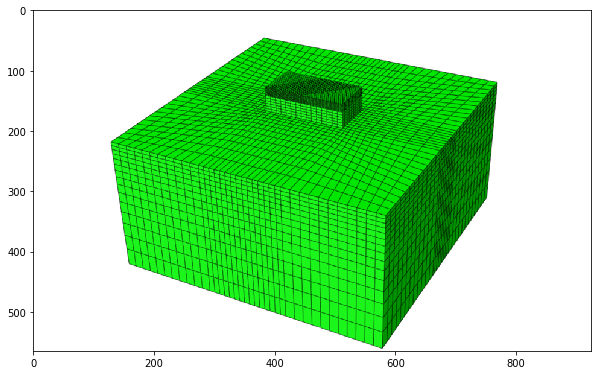

In [0]:
img = mpimg.imread(os.path.join(work_dir, 'Finite_Element_Model.png'))
plt.figure(figsize = (10, 10))
img_plot = plt.imshow(img)

where the small block on the top is the part being printed. We are particularly interested in the temperature distribution near the laser point during the simulations. Thus each simulation generated one file that records simulated temperature at FE nodes near the laser point. Such data are separated into two cases:

1.   Laser path does not interact with part boundary

2.   Laser path interacts with part boundary, and with varying angles

For each case, the task is as follows:

1.   **Given laser power, laser speed, x/y/z coordinate of a specific point, predict the temperature at that point; also, given laser power and laser speed, predict the meltpool L/width/depth;** 

2.   **Given laser power, laser speed, edge angle, edge distance, laser direction, x/y/z coordinate of a specific point, predict the temperature at that point; also, given laser power, laser speed, edge angle, edge distance, and laser direction, predict the meltpool L/width/depth.**

We'll look at a simple exploration and visualization of these data in the next section.

[1] https://www.3ds.com/fileadmin/PRODUCTS/SIMULIA/PDF/whitepapers/A-metallurgical-phase-transformation-framework-applied-to-SLM-additive.pdf

# 3. Data Exploration
NOTE: All **temperature** and **meltpool length/width/depth** data have been normalized with min-max feature scaling. Data from Case 1 and Case 2 are normalized independently.


## Case 1: no boundary effects
Below is an example contour plot of temperature at the moment data is recorded,

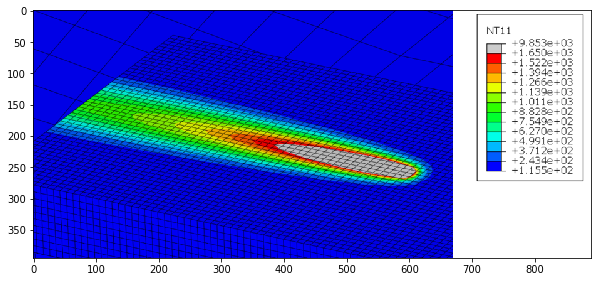

In [0]:
img = mpimg.imread(os.path.join(work_dir, 'Meltpool.png'))
plt.figure(figsize = (10, 10))
img_plot = plt.imshow(img)

where the grey areas can be interpreted as the meltpool that will eventually cool down to become solid. In Case 1, laser path is the same among all simulations (straight through the center of the surface), the only differences are the laser power and speed. We can select a random combination of these two and look at the training data,

In [0]:
ls = np.linspace(0.6, 1.5, 19)
lp = np.linspace(100, 400, 13)
random_file_name = (str(round(random.choice(ls), 2)).replace('.', '_') 
                 +  'ms_'
                 +  str(int(random.choice(lp))) 
                 +  'W.csv')
try:
    random_file = pd.read_csv(os.path.join(work_dir, '1/Training', random_file_name), index_col = False)
except:
    random_file = pd.read_csv(os.path.join(work_dir, '1/Validation', random_file_name), index_col = False)
print(random_file_name)
random_file.head(100)

NameError: ignored

The first three columns are X, Y and Z coordinates related with the measured (normalized) temperature in the fourth column. The coordinates are with respect to the laser point. Here is a rough illustration,

> Indented block



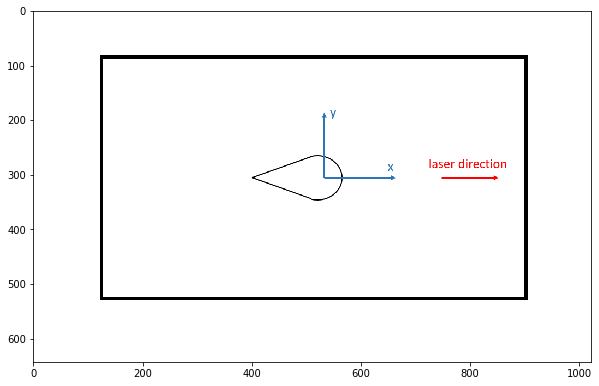

In [0]:
img = mpimg.imread(os.path.join(work_dir, '1', 'Illustration.png'))
plt.figure(figsize = (10, 10))
img_plot = plt.imshow(img)

The temperatures are taken within a fixed sized block near the laser point. Specifically ,

**-1.51 <= X_Coord <= 0.181**, 

**-0.211 <= Y_Coord <= 0** (Due to expected symmetry),

**Z_Coord <= 0** (Due to laser scanning on the top surface).

If we choose a temperature, we can also look at the projected meltpool shape using the coordinates,

In [0]:
random_file_name = (str(round(random.choice(ls), 2)).replace('.', '_') 
                 +  'ms_'
                 +  str(int(random.choice(lp))) 
                 +  'W.csv')
# print(random_file_name)
try:
    random_file = pd.read_csv(os.path.join(work_dir, '1/Training', random_file_name), index_col = False)
except:
    random_file = pd.read_csv(os.path.join(work_dir, '1/Validation', random_file_name), index_col = False)
# choose a random temperature
temp_chosen = 0.04
# print(random_file_name)
# all points with at lease this temperature will be plotted
scatter_points = random_file[random_file['T'] >= temp_chosen]
# print(scatter_points)
fig = plt.figure(figsize = (20, 5))
ax = fig.add_subplot(111)
ax.set_xlim(-1.5, 0.18)
ax.set_ylim(-0.21, 0.21)
scatter_points.plot.scatter(x = 'X_Coord', y = 'Y_Coord', s = scatter_points['T'] * 1000, ax = ax);

NameError: ignored

Within each folder ("Training", "Validation", or "Testing"), a file named "mpd.csv" records the meltpool length, width and depth measurements for each of the simulation in that folder (normalized). 

**Generate the Training Dataset**


In [0]:
Train1 = pd.DataFrame()
ls = np.linspace(0.6, 1.5, 19)
lp = np.linspace(100, 400, 13)
look = pd.read_csv(os.path.join(work_dir, '1/Training', 'mpd.csv'), index_col = False)
for speed in list(ls):
  for power in list(lp):
    try:
      file_name = (str(round(speed,2)).replace('.', '_') 
                      +  'ms_'
                      +  str(int(power))
                      +  'W.csv')
      NeedSpeed = round(speed,2)
      NeedPower = power
      file = pd.read_csv(os.path.join(work_dir, '1/Training', file_name), index_col = False)
      file = file.sample(n=50)
      file['P'] = NeedPower
      file['S'] = NeedSpeed
      Train1 = pd.concat([Train1,file])
    except:
      continue

**Generate the validation set**

In [0]:
Valid1 = pd.DataFrame()
ls = np.linspace(0.6, 1.5, 19)
lp = np.linspace(100, 400, 13)
for speed in list(ls):
  for power in list(lp):
    try:
      file_name = (str(round(speed,2)).replace('.', '_') 
                      +  'ms_'
                      +  str(int(power))
                      +  'W.csv')
      NeedSpeed = round(speed,2)
      NeedPower = power
      file = pd.read_csv(os.path.join(work_dir, '1/Validation', file_name), index_col = False)
      # file = file.sample(n=50)
      file['P'] = NeedPower
      file['S'] = NeedSpeed

      Valid1 = pd.concat([Valid1,file])
    except:
      continue

In [0]:
Valid1

NameError: ignored

### **Case 1 Exploratory Data Analysis**

In [0]:
sns.pairplot(Train1, diag_kind="kde")

NameError: ignored

In [0]:
Train1.corr()

NameError: ignored

In [0]:
sns.pairplot(Valid1, diag_kind="kde")

NameError: ignored

# **Insights:**
1. There are a lot of linear relationships in the features which is encouraging
2. The Training sample generated is a sample of the population is representative of the total population as we see that the distribution of points in the training and validation sets look alike. We can expect a small varaiance using another subsample.
3. The Power seems to have good co-relation with most of the features and this also makes sense through Physics. For example, as the power increases the depth of laser penetration increases.
4. The temperature feature looks notoriously noisy. That is probably because of the heat distribution captures which is probably already noisy and the fact that it was restricted may be causing this.
5. It is interesting to see the X,Y,Z variation with Terature, that confirms how the experiment was carried out.
6. The power variations with X,Y,Z show that most of the data points were captured during sampling.
7. Interesting ideas may include looking at Markov Chains Models of data in a time based setting and also trying out bayesian approaches.
8. Because R^2 is the metric, Linear Regressors (or) Boosted trees with linear regressors should perform well.

**Combine the Data with the Values of the Melth D, W and L for both training and validation**


In [0]:
#Training

look = pd.read_csv(os.path.join(work_dir, '1/Training', 'PoolDimensions.csv'), index_col = False)

def d(row):
  result = look[(look['S'] == row['S']) & (look['P'] == row['P'])]['D'].values[0]
  return result
Train1['D'] = Train1.apply(d, axis=1)


def w(row):
  result = look[(look['S'] == row['S']) & (look['P'] == row['P'])]['W'].values[0]
  return result
Train1['W'] = Train1.apply(w, axis=1)


def l(row):
  result = look[(look['S'] == row['S']) & (look['P'] == row['P'])]['L'].values[0]
  return result
Train1['q
'] = Train1.apply(l, axis=1)


In [0]:
#Validation

look = pd.read_csv(os.path.join(work_dir, '1/Validation', 'mpd.csv'), index_col = False)

Valid1['L'] = Valid1.apply(l, axis=1)
Valid1['P'] = Valid1.apply(w, axis=1)
Valid1['Q'] = Valid1.apply(d, axis=1)

In [0]:
Train1

NameError: ignored

**Predict the Terature using the Power, Speed, X,Y,Z coordinates**

In [0]:
y_train = Train1['T']
X_train = Train1.drop(columns = ['Output','In1','In2','In3'])
y_test = Valid1['T'] 
X_test = Valid1.drop(columns = ['Output','In1','In2','In3'])

In [0]:
X_test

NameError: ignored

In [0]:
from xgboost import plot_importance

model12 = xgboost.XGBRegressor()
model12.fit(X_train,y_train)
Pred = model12.predict(X_test)
print(r2_score(Pred,y_test))
print(model12.feature_importances_)
plot_importance(model12)
plt.plot(Pred,y_test)
plt.show()

NameError: ignored

In [0]:
plt.scatter(X_train['X_Coord'],y_train)
plt.xlabel('X_Coord')
plt.ylabel('T')
plt.show()
plt.scatter(X_train['Y_Coord'],y_train)
plt.xlabel('Y_Coord')
plt.ylabel('T')
plt.show()
plt.scatter(X_train['Z_Coord'],y_train)
plt.xlabel('Z_Coord')
plt.ylabel('T')

NameError: ignored

**Predict the Melt D, W, Height with the Laser Power and Speed data**

In [0]:
from mpl_toolkits import mplot3d

y_train = Train1['D']
X_train = Train1.drop(columns = ['D','T','X_Coord','Y_Coord','Z_Coord','W','L'])
plt.scatter(X_train['P'],y_train)
plt.xlabel('Power')
plt.ylabel('D')
plt.show()
plt.scatter(X_train['S'],y_train)
plt.xlabel('Speed')
plt.ylabel('D')
y_test = Valid1['D']
X_test = Valid1.drop(columns = ['D','T','X_Coord','Y_Coord','Z_Coord','W','L'])
model2 = xgboost.XGBRegressor()
model2.fit(X_train,y_train)
Pred = model2.predict(X_test)
print(r2_score(Pred,y_test))
plot_importance(model2)
plt.show()


y_train = Train1['W']
X_train = Train1.drop(columns = ['W','T','X_Coord','Y_Coord','Z_Coord','D', 'L'])
plt.scatter(X_train['P'],y_train)
plt.xlabel('Power')
plt.ylabel('W')
plt.show()
plt.scatter(X_train['S'],y_train)
plt.xlabel('Speed')
plt.ylabel('W')
y_test = Valid1['W']
X_test = Valid1.drop(columns = ['W','T','X_Coord','Y_Coord','Z_Coord','D', 'L'])
model3 = xgboost.XGBRegressor()
model3.fit(X_train,y_train)
Pred = model3.predict(X_test)
print(r2_score(Pred,y_test))
plot_importance(model3)

plt.show()

y_train = Train1['L']
X_train = Train1.drop(columns = ['L','T','X_Coord','Y_Coord','Z_Coord','D','W'])

y_test = Valid1['L']
X_test = Valid1.drop(columns = ['L','T','X_Coord','Y_Coord','Z_Coord','D','W'])
model4 = xgboost.XGBRegressor()
model4.fit(X_train,y_train)
Pred = model4.predict(X_test)
print(r2_score(Pred,y_test))
plt.scatter(X_train['P'],y_train)
plt.xlabel('Power')
plt.ylabel('L')
plot_importance(model4)


NameError: ignored

**Building Interpretable models**

In [0]:
from interpret import show
from interpret.data import Marginal

marginal = Marginal().explain_data(X_train, y_train, name = 'Train Data')
show(marginal)

ModuleNotFoundError: ignored

In [0]:
from interpret.glassbox import ExplainableBoostingRegressor, LinearRegression, RegressionTree
ebm = ExplainableBoostingRegressor(random_state=1)
ebm.fit(X_train, y_train)   #Works on dataframes and numpy arrays

In [0]:
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)

In [0]:
from interpret import show
from interpret.perf import RegressionPerf

ebm_perf = RegressionPerf(ebm.predict).explain_perf(X_test, y_test, name='EBM')
show(ebm_perf)

**Testing the model**

In [0]:
ls = [0.62, 0.83, 1.02, 1.23, 1.42]
lp = [110, 170, 230, 320, 380]
def d(row):
  result = look[(look['po'] == row['S']) & (look['P'] == row['P'])]['Melt_Pool_D'].values[0]
  return result


def w(row):
  result = look[(look['po'] == row['S']) & (look['P'] == row['P'])]['Melt_Pool_W'].values[0]
  return result


def l(row):
  result = look[(look['po'] == row['S']) & (look['P'] == row['P'])]['Melt_Pool_L'].values[0]
  return result


for speed in list(ls):
  for power in list(lp):
    file_name = (str(round(speed, 2)).replace('.', '_') 
                +  'ms_'
                +  str(int(power)) 
                +  'W.csv')
    file = pd.read_csv(os.path.join(work_dir, '1/Testing', file_name), index_col = False)
    file = file.drop(columns = ['Unnamed: 4'])
    # print(file)
    look = pd.read_csv(os.path.join(work_dir, '1/Testing', 'mpd.csv'), index_col = False)
    file['P'] = power
    file['S'] = round(speed,2)
    X = file.drop(columns = ['T'])
    # print(X)
    file['T']= model1.predict(X)
    # file.to_csv(work_dir+'/Submissions/MachineLearningtoBuildMachines/1/'+file_name)
    # print(file)

In [0]:
meltpool_testing = pd.read_csv(os.path.join(work_dir, '1/Testing', 'mpd.csv'), index_col = False)
X = meltpool_testing.drop(columns = ['Melt_Pool_L','Melt_Pool_W','Melt_Pool_D'])
X = X.rename(columns={"po": "S", "P": "P"})
cols = X.columns.tolist()
cols =  ['P', 'S']
X = X[cols]
meltpool_testing['Melt_Pool_D'] = model2.predict(X)
meltpool_testing['Melt_Pool_W'] = model3.predict(X)
meltpool_testing['Melt_Pool_L'] = model4.predict(X)
# meltpool_testing.to_csv(work_dir+'/Submissions/MachineLearningtoBuildMachines/1/MeltPool_Testing.csv')

## Case 2: boundary effects
When the laser point goes near the edge of the part surface, the temperature field will be significantly affected due to the difference in thermal conductivity and radiation properties. In this case, the temperature is recorded at various frames during the simulation, while the angle of the laser path w.r.t. the part edge will also become a parameter. We can select a combination of laser power, laser speed, and edge angle to look at the data,

In [0]:
ls = np.linspace(0.6, 1.5, 19)
lp = np.linspace(100, 400, 13)
la = [10, 30, 50, 70, 90]
random_file_name = (str(round(random.choice(ls), 2)).replace('.', '_') 
                 +  'ms_'
                 +  str(int(random.choice())) 
                 +  'W_'
                 +  str(random.choice(la))
                 +  'Deg.csv')
try:
    random_file = pd.read_csv(os.path.join(work_dir, '2/Training', random_file_name), index_col = False)
except:
    random_file = pd.read_csv(os.path.join(work_dir, '2/Validation', random_file_name), index_col = False)
print(random_file_name)


The first three columns are X, Y and Z coordinates related with the measured (normalized) temperature in the sixth column. The coordinates are with respect to the laser point. The fourth column is the minimal distance between this point and the surface edge. The fifth column is denotes whether the laser is traveling towards the edge or away from it (1 means towards, -1 means away). Note that the absolute most of the data will be from frames where the laser is traveling away from the edge. Here is a rough illustration,

In [0]:
img = mpimg.imread(os.path.join(work_dir, '2', 'Illustration.png'))
plt.figure(figsize = (10, 10))
img_plot = plt.imshow(img)

The temperatures are taken within a fixed sized block near the laser point. Specifically ,

**-1.51 <= X_Coord <= 0.181**, 

**-0.211 <= Y_Coord <= 0.211**,

**Z_Coord <= 0** (Due to laser scanning on the top surface).

If we choose a temperature, we can also look at the projected meltpool shape using the coordinates,

In [0]:
random_file_name = (str(round(random.choice(ls), 2)).replace('.', '_') 
                 +  'ms_'
                 +  str(int(random.choice(lp))) 
                 +  'W_'
                 +  str(random.choice(la))
                 +  'Deg.csv')
try:
    random_file = pd.read_csv(os.path.join(work_dir, '2/Training', random_file_name), index_col = False)
except:
    random_file = pd.read_csv(os.path.join(work_dir, '2/Validation', random_file_name), index_col = False)
# choose a random temperature
temp_chosen = 0.04
print(random_file_name)
# each different combination of "Edge_Distance" and "Laser_Direction" represents a different frame
frames = [pd.DataFrame(y) for x, y in random_file.groupby(['Edge_Distance', 'Laser_Direction'], as_index = False)]
fig = plt.figure(figsize = (20, 50))
# plot at most 30 frames
num_plots = min(30, len(frames))
for i_plot in range(num_plots):
    frame = frames[i_plot]
    # all points with at lease this temperature will be plotted
    scatter_points = frame[frame['T'] >= temp_chosen]
    ax = fig.add_subplot(10, 3, i_plot + 1)
    ax.set_xlim(-1.5, 0.18)
    ax.set_ylim(-0.21, 0.21)
    scatter_points.plot.scatter(x = 'X_Coord', y = 'Y_Coord', s = scatter_points['T'] * 1000, ax = ax);

Within each folder ("Training", "Validation", or "Testing"), a file named "mpd.csv" records the meltpool length, width and depth measurements for each of the frame present in that folder (normalized).

In [0]:
meltpool_training = pd.read_csv(os.path.join(work_dir, '2/Training', 'mpd.csv'), index_col = False)
meltpool_training.head(10)

**Get the Training and Validation Sets**

In [0]:
Train2 = pd.DataFrame()
ls = np.linspace(0.6, 1.5, 19)
lp = np.linspace(100, 400, 13)
la = [10, 30, 50, 70, 90]

for speed in list(ls):
  for power in list(lp):
    for laser in list(la):
      try:
        file_name = (str(round(speed, 2)).replace('.', '_') 
                  +  'ms_'
                  +  str(int(power)) 
                  +  'W_'
                  +  str(laser)
                  +  'Deg.csv')
        NeedSpeed = round(speed,2)
        NeedPower = power
        file = pd.read_csv(os.path.join(work_dir, '2/Training', file_name), index_col = False)
        file = file.sample(n = 100)
        file['P'] = NeedPower
        file['S'] = NeedSpeed
        file['A'] = laser
        Train2 = pd.concat([Train2,file])
      except:
        continue

In [0]:
Valid2 = pd.DataFrame()
ls = np.linspace(0.6, 1.5, 19)
lp = np.linspace(100, 400, 13)
la = [10, 30, 50, 70, 90]

for speed in list(ls):
  for power in list(lp):
    for laser in list(la):
      try:
        file_name = (str(round(speed, 2)).replace('.', '_') 
                  +  'ms_'
                  +  str(int(power)) 
                  +  'W_'
                  +  str(laser)
                  +  'Deg.csv')
        NeedSpeed = round(speed,2)
        NeedPower = power
        file = pd.read_csv(os.path.join(work_dir, '2/Validation', file_name), index_col = False)
        file = file.sample(n = 50)
        file['P'] = NeedPower
        file['S'] = NeedSpeed
        file['A'] = laser
        Valid2 = pd.concat([Valid2,file])
      except:
        continue

In [2]:
sns.pairplot(Train2, diag_kind="kde")

NameError: ignored

In [3]:
sns.pairplot(Valid2, diag_kind="kde")

NameError: ignored

In [0]:
sns.pairplot(Train2, diag_kind="kde")

# **Insights:**
1. Talking about relationships, this model does not seem to have a lot in terms of pattern going on.
2. Again, The Training sample generated is a sample of the population is representative of the total population as we see that the distribution of points in the training and validation sets look alike. We can expect a small varaiance using another subsample.
3. Similar to the past results, The Power seems to have good co-relation with most of the features and this also makes sense through Physics. For example, as the power increases the depth of laser penetration increases.
4. What's really interesting to see is how the temperature varies with the X,Y,Z coordinates. With X values, it is evident that with decreasing x, the temperature drops. With Y, the temperature is maximum at the center and with Z, with increasing depth, the temperature drops. This makes sense physics wise and is interesting to note.
5. This dataset may require a little more involved model building in terms of capturing relationships.

**Match both with the melt depth,length and width**

In [0]:
look = pd.read_csv(os.path.join(work_dir, '2/Training', 'mpd.csv'), index_col = False)

def d(row):
  result = look[(look['po'] == row['S']) & (look['P'] == row['P'])]['Melt_Pool_D'].values[0]
  return result


def w(row):
  result = look[(look['po'] == row['S']) & (look['P'] == row['P'])]['Melt_Pool_W'].values[0]
  return result


def l(row):
  result = look[(look['po'] == row['S']) & (look['P'] == row['P'])]['Melt_Pool_L'].values[0]
  return result

Train2['L'] = Train2.apply(l, axis=1)
Train2['W'] = Train2.apply(w, axis=1)
Train2['D'] = Train2.apply(d, axis=1)


look = pd.read_csv(os.path.join(work_dir, '2/Validation', 'mpd.csv'), index_col = False)

Valid2['L'] = Valid2.apply(l, axis=1)
Valid2['W'] = Valid2.apply(w, axis=1)
Valid2['D'] = Valid2.apply(d, axis=1)

In [0]:
Train2

In [0]:
"""
One hot encoding produced sub par results for the directionality column.
There may be a continuous relationship that is not explicitly coded.
"""
# # Get one hot encoding of columns B
# one_hot = pd.get_dummies(Train2['Laser_Direction'])
# # Drop column B as it is now encoded
# Train2 = Train2.drop('Laser_Direction',axis = 1)
# # Join the encoded df
# Train2 = Train2.join(one_hot)

# # Get one hot encoding of columns B
# one_hot = pd.get_dummies(Valid2['Laser_Direction'])
# # Drop column B as it is now encoded
# Valid2 = Valid2.drop('Laser_Direction',axis = 1)
# # Join the encoded df
# Valid2 = Valid2.join(one_hot)

**Predicting the temperature**

In [0]:
y_train = Train2['T']
X_train = Train2.drop(columns = ['T','L','W','D'])
y_test = Valid2['T']
X_test = Valid2.drop(columns = ['T','L','W','D'])
model = xgboost.XGBRegressor()
model.fit(X_train,y_train)
Pred = model.predict(X_test)
print(r2_score(Pred,y_test))
# plt.scatter(X_train['Z_Coord'],y_train)
# plt.xlabel('Z Coordinate')
# plt.ylabel('Terature')
# plt.show()
plot_importance(model)


**Predicting the Laser L, W, D**

In [0]:
# """
# Trying TPOT for the L Prediction because of poor performance of Vanilla models without any parameterization. 
# This is to save time running through grid search
# """
# y_train = Train2['L']
# X_train = Train2.drop(columns = ['L','T','X_Coord','Y_Coord','Z_Coord','D','W'])
# y_test = Valid2['L']
# X_test = Valid2.drop(columns = ['L','T','X_Coord','Y_Coord','Z_Coord','D','W'])
# from tpot import TPOTRegressor
# tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42, scoring = 'r2')
# tpot.fit(X_train, y_train)
# print(tpot.score(X_test, y_test))

In [0]:
y_train = Train2['D']
X_train = Train2.drop(columns = ['D','T','X_Coord','Y_Coord','Z_Coord','W','L'])
# print(X_train)
y_test = Valid2['D']
X_test = Valid2.drop(columns = ['D','T','X_Coord','Y_Coord','Z_Coord','W','L'])
model2 = xgboost.XGBRegressor()
model2.fit(X_train,y_train)
Pred = model2.predict(X_test)
print(r2_score(Pred,y_test))
plot_importance(model2)

plt.scatter(X_train['P'],y_train)
plt.show()
y_train = Train2['W']
X_train = Train2.drop(columns = ['W','T','X_Coord','Y_Coord','Z_Coord','D', 'L'])
# print(X_train)
y_test = Valid2['W']
X_test = Valid2.drop(columns = ['W','T','X_Coord','Y_Coord','Z_Coord','D', 'L'])
model3 = xgboost.XGBRegressor()
model3.fit(X_train,y_train)
Pred = model3.predict(X_test)
print(r2_score(Pred,y_test))
plot_importance(model3)

from sklearn.ensemble import RandomForestRegressor
# plt.scatter(X_train['P'],y_train)
# plt.show()
# Get one hot encoding of columns B
one_hot = pd.get_dummies(Train2['Laser_Direction'])
# Drop column B as it is now encoded
T1rain2 = Train2.drop('Laser_Direction',axis = 1)
# Join the encoded df
T1rain2 = Train2.join(one_hot)

# Get one hot encoding of columns B
one_hot = pd.get_dummies(Valid2['Laser_Direction'])
# Drop column B as it is now encoded
V1alid2 = Valid2.drop('Laser_Direction',axis = 1)
# Join the encoded df
V1alid2 = Valid2.join(one_hot)
print(Train2)
y_train = np.log(Train2['L'])
X_train = Train2.drop(columns = ['L','T','X_Coord','Y_Coord','Z_Coord','D','W'])
y_test = Valid2['L']
X_test = Valid2.drop(columns = ['L','T','X_Coord','Y_Coord','Z_Coord','D','W'])
model = RandomForestRegressor(max_depth=50,n_estimators=100)
model.fit(X_train,y_train)
Pred = model4.predict(X_test)
print(r2_score(Pred,y_test))

print(X_train)
print(y_train)

# plt.scatter(X_train['P'],y_train)
# plt.show()

In [0]:
y_train = Train2['L']
X_train = Train2.drop(columns = ['L','T','X_Coord','Y_Coord','Z_Coord','D','W'])
y_test = Valid2['L']
X_test = Valid2.drop(columns = ['L','T','X_Coord','Y_Coord','Z_Coord','D','W'])
model4 = xgboost.XGBRegressor(n_estimators=150,loss = 'l1')
model4.fit(X_train,y_train)
Pred = model4.predict(X_test)
print(r2_score(Pred,y_test))
plot_importance(model4)
print(y_train)
plt.scatter(X_train['P'],y_train)
plt.show()

In [0]:
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
y_train = Train2['L']
X_train = Train2.drop(columns = ['L','T','X_Coord','Y_Coord','Z_Coord','D','W'])
y_test = Valid2['L']
X_test = Valid2.drop(columns = ['L','T','X_Coord','Y_Coord','Z_Coord','D','W'])
def R_squared(y, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
    r2 = tf.subtract(1.0, tf.div(residual, total))
    return r2
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(X.keys())]),
    layers.Dense(100, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse',R_squared])
  return model
model = build_model()
EPOCHS = 1000

history = model.fit(
  X_train, y_train,
  epochs=EPOCHS,validation_data=(X_test, y_test), verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)


**Testing for temperature**


In [0]:
ls = [0.62, 0.77, 0.93, 1.07, 1.38, 1.47]
lp = [110, 160, 240, 310, 390]
la = [20, 40, 60, 80]


for speed in list(ls):
  for power in list(lp):
    for laser in list(la):
      file_name = (str(round(speed, 2)).replace('.', '_') 
                 +  'ms_'
                 +  str(int(power)) 
                 +  'W_'
                 +  str(laser)
                 +  'Deg.csv')
      # print(file_name)
      try:
        file = pd.read_csv(os.path.join(work_dir, '2/Testing', file_name), index_col = False)
        # look = pd.read_csv(os.path.join(work_dir, '2/Testing', 'mpd.csv'), index_col = False)
        file['P'] = power
        file['S'] = round(speed,2)
        file[''] = laser
        file = file.drop(columns = ['T'])
        file['T']= model.predict(file)
        # file.to_csv(work_dir+'/Submissions/MachineLearningtoBuildMachines/2/'+file_name)
        # print(file)
      except:
        continue

**Testing for the 3 parameters**

In [0]:
meltpool_testing = pd.read_csv(os.path.join(work_dir, '2/Testing', 'mpd.csv'), index_col = False)
print(meltpool_testing)
X = meltpool_testing.drop(columns = ['Melt_Pool_L','Melt_Pool_W','Melt_Pool_D'])
X = X.rename(columns={"pp": "S", "P": "P","Edge_Angle":"A"})
cols = X.columns.tolist()
cols =  ['Edge_Distance', 'Laser_Direction', 'P', 'S', 'A']
X = X[cols]


meltpool_testing['Melt_Pool_D']= model2.predict(X)
print(model2.predict(X))
meltpool_testing['Melt_Pool_W'] = model3.predict(X)
print(model3.predict(X))
a = [np.mean(y_train)] * X.shape[0]
meltpool_testing['Melt_Pool_L'] = a
print(a)
meltpool_testing.to_csv(work_dir+'/Submissions/MachineLearningtoBuildMachines/2/MeltPool_Testing.csv')

# 4. Prediction Evaluation

## Training Data

In this section, a dummy regressor always predicting mean of the training set will be used to demonstrate prediction evaluation for Case 1. **The final evaluation metrics is R^2 (coefficient of determination) regression score.** For melt pool sizes, the R^2 is averaged among length, width, and depth predictions.

First, for temperature predictions, two of the features (laser speed and power) are in the file name. Plus the coordinates, there are 5 predetermined features in total,

In [0]:
# all possible values of laser speed and power
ls = np.linspace(0.6, 1.5, 19)
lp = np.linspace(100, 400, 13)

# form training data and target
initialized = False
count = 0
for laser_speed in ls:
    for laser_power in lp:
        file_name = (str(round(laser_speed, 2)).replace('.', '_') 
                  +  'ms_'
                  +  str(int(laser_power)) 
                  +  'W.csv')
        # only taking data from the training set
        try:
            data_file = pd.read_csv(os.path.join(work_dir, '1/Training', file_name), index_col = False)
        except:
            continue

        if initialized:
            y_new = data_file.pop('T').values
            X_new = data_file.values
            # add laser speed and power as another two features to X
            laser_speed_col = np.full((X_new.shape[0], 1), laser_speed)
            laser_power_col = np.full((X_new.shape[0], 1), laser_power)
            X_new = np.c_[laser_speed_col, laser_power_col, X_new]
            X = np.r_[X, X_new]
            y = np.r_[y, y_new]
        else:
            # initialize X
            y = data_file.pop('T').values
            X = data_file.values
            # add laser speed and power as another two features to X
            laser_speed_col = np.full((X.shape[0], 1), laser_speed)
            laser_power_col = np.full((X.shape[0], 1), laser_power)
            X = np.c_[laser_speed_col, laser_power_col, X]
            initialized = True
        

The sizes of training data and target,

In [0]:
X.shape

In [0]:
y.shape

Dummy regressor that always predicts mean,

In [0]:
dummy_regr = DummyRegressor(strategy = 'mean')
dummy_regr.fit(X, y)
dummy_prediction = dummy_regr.predict(X)
r2_score(y, dummy_prediction)

The Validation examples are in the "Validation" folder,

In [0]:
initialized = False
for laser_speed in ls:
    for laser_power in lp:
        file_name = (str(round(laser_speed, 2)).replace('.', '_') 
                  +  'ms_'
                  +  str(int(laser_power)) 
                  +  'W.csv')
        try:
            data_file = pd.read_csv(os.path.join(work_dir, '1/Validation', file_name), index_col = False)
        except:
            continue

        if initialized:
            y_val_new = data_file.pop('T').values
            X_val_new = data_file.values
            laser_speed_col = np.full((X_val_new.shape[0], 1), laser_speed)
            laser_power_col = np.full((X_val_new.shape[0], 1), laser_power)
            X_val_new = np.c_[laser_speed_col, laser_power_col, X_val_new]
            X_val = np.r_[X_val, X_val_new]
            y_val = np.r_[y_val, y_val_new]
        else:
            y_val = data_file.pop('T').values
            X_val = data_file.values
            laser_speed_col = np.full((X_val.shape[0], 1), laser_speed)
            laser_power_col = np.full((X_val.shape[0], 1), laser_power)
            X_val = np.c_[laser_speed_col, laser_power_col, X_val]
            initialized = True

R^2 score

In [0]:
dummy_prediction = dummy_regr.predict(X_val)
r2_score(y_val, dummy_prediction)

Second, for meltpool sizes prediction, all predetermined features are in the same file,

In [0]:
meltpool_training = pd.read_csv(os.path.join(work_dir, '1/Training', 'mpd.csv'), index_col = False)
meltpool_len = meltpool_training.pop('Melt_Pool_L').values
meltpool_wid = meltpool_training.pop('Melt_Pool_W').values
meltpool_dep = meltpool_training.pop('Melt_Pool_D').values
y = np.c_[meltpool_len, meltpool_wid, meltpool_dep]
X = meltpool_training.values

The sizes of training data and target,

In [0]:
X.shape

In [0]:
y.shape

Dummy regressor that always predicts mean,

In [0]:
dummy_regr = DummyRegressor(strategy = 'mean')
dummy_regr.fit(X, y)
dummy_prediction = dummy_regr.predict(X)
r2_score(y, dummy_prediction, multioutput = 'uniform_average')

The Validation examples are in the "Validation" folder,

In [0]:
meltpool_validation = pd.read_csv(os.path.join(work_dir, '1/Validation', 'mpd.csv'), index_col = False)
meltpool_len = meltpool_validation.pop('Melt_Pool_L').values
meltpool_wid = meltpool_validation.pop('Melt_Pool_W').values
meltpool_dep = meltpool_validation.pop('Melt_Pool_D').values
y_val = np.c_[meltpool_len, meltpool_wid, meltpool_dep]
X_val = meltpool_validation.values

R^2 score

In [0]:
dummy_prediction = dummy_regr.predict(X_val)
r2_score(y_val, dummy_prediction, multioutput = 'uniform_average')

## Testing Data
The "Testing" folder for either case contains the template files for final outputs.

For Case 1, the possible laser speed and power combinations are as follows,

In [0]:
ls = [0.62, 0.83, 1.02, 1.23, 1.42]
lp = [110, 170, 230, 320, 380]

random_file_name = (str(round(random.choice(ls), 2)).replace('.', '_') 
                 +  'ms_'
                 +  str(int(random.choice(lp))) 
                 +  'W.csv')

random_file = pd.read_csv(os.path.join(work_dir, '1/Testing', random_file_name), index_col = False)
print(random_file_name)
random_file.head(10)

In [0]:
meltpool_testing = pd.read_csv(os.path.join(work_dir, '1/Testing', 'mpd.csv'), index_col = False)
meltpool_testing.head(10)

For Case 2, the possible laser speed, power and angle combinations are as follows,

In [0]:
ls = [0.62, 0.77, 0.93, 1.07, 1.38, 1.47]
lp = [110, 160, 240, 310, 390]
la = [20, 40, 60, 80]
random_file_name = (str(round(random.choice(ls), 2)).replace('.', '_') 
                 +  'ms_'
                 +  str(int(random.choice(lp))) 
                 +  'W_'
                 +  str(random.choice(la))
                 +  'Deg.csv')
random_file = pd.read_csv(os.path.join(work_dir, '2/Testing', random_file_name), index_col = False)
print(random_file_name)
random_file.head(10)

In [0]:
meltpool_testing = pd.read_csv(os.path.join(work_dir, '2/Testing', 'mpd.csv'), index_col = False)
meltpool_testing.head(10)